## Import libraries

In [1]:
import pandas as pd
import numpy as np
!pip install yfinance
import yfinance as yf  
from datetime import date
from pandas_datareader import data as pdr
yf.pdr_override()

     |████████████████████████████████| 6.4 MB 35.4 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


# Read data

In [2]:
def SaveData(df, filename):
  df.to_csv(filename + '.csv')
today = date.today()
dataname='^NSEI'+'_'+str(today)
data=pdr.get_data_yahoo('^NSEI', start='2015-01-01', end=today)
SaveData(data, dataname)
data= pd.read_csv(dataname+'.csv')
# Create a data folder in your current dir.



[*********************100%***********************]  1 of 1 completed


In [3]:
# drop not required column
data.drop(columns=['Adj Close'], inplace=True)

In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data

,Date,Open,High,Low,Close,Volume
0,2015-01-02,8288.700195,8410.599609,8288.700195,8395.450195,101900
1,2015-01-05,8407.950195,8445.599609,8363.900391,8378.400391,118200
2,2015-01-06,8325.299805,8327.849609,8111.350098,8127.350098,172800
3,2015-01-07,8118.649902,8151.200195,8065.450195,8102.100098,164100
4,2015-01-08,8191.399902,8243.500000,8167.299805,8234.599609,143800
...,...,...,...,...,...,...
1788,2022-04-12,17584.849609,17595.300781,17442.349609,17530.300781,266000
1789,2022-04-13,17599.900391,17663.650391,17457.400391,17475.650391,245100
1790,2022-04-18,17183.449219,17237.750000,17067.849609,17173.650391,376100
1791,2022-04-19,17258.949219,17275.650391,16824.699219,16958.650391,401400


## Plot data

In [5]:
import matplotlib.pyplot as plt

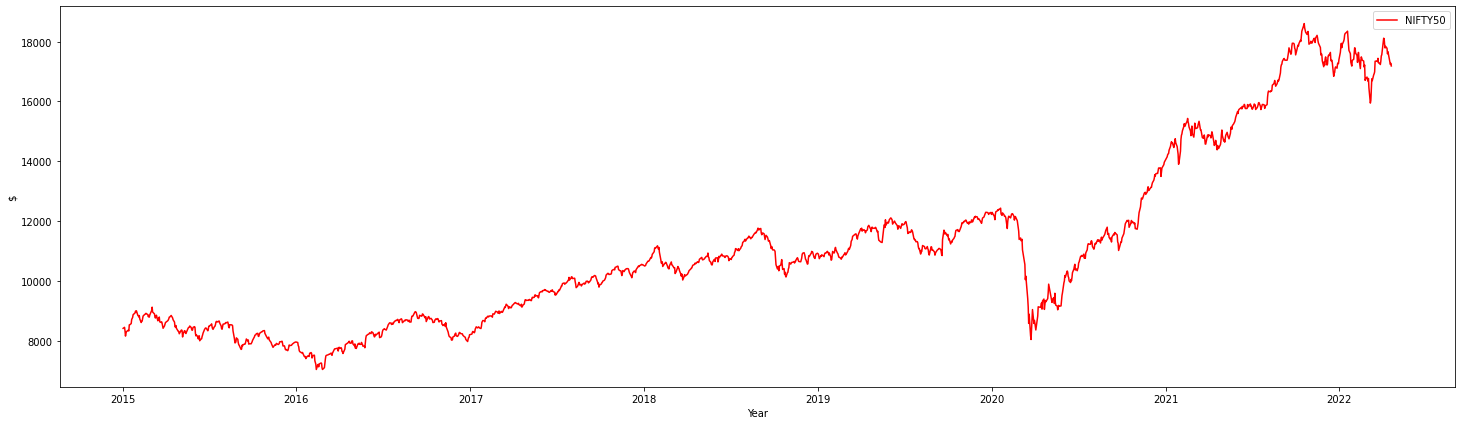

In [6]:
fig = plt.figure(figsize = (25, 7))
plt.plot(data.Date,data.High, color = 'red', label = 'NIFTY50')
plt.xlabel('Year')
plt.ylabel('$')
plt.legend()
plt.show()

# Splitting data into training and testing

In [7]:
data.shape
#rows, colums

(1793, 6)

In [8]:
# 80% will be used for traning, and 20% for testing

train_size = 0.8       # 80%
split_index = int(train_size * data.shape[0])

factors_column = ['Open', 'High', 'Low', 'Close', 'Volume']
y_col_index = 3 # Close

train_set = data[factors_column].values[:split_index]
test_set = data[factors_column].values[split_index:]

In [9]:
split_index

1434

# Scaling data between 0-1
for better learning

In [10]:
from sklearn.preprocessing import MinMaxScaler

# scale our price from 0 to 1

sc = MinMaxScaler(feature_range = (0, 1))
train_set_scaled = sc.fit_transform(train_set)
test_set_scaled = sc.fit_transform(test_set)
print(train_set)
#print(test_set)
print(train_set_scaled)
#print(test_set_scaled)

[[  8288.70019531   8410.59960938   8288.70019531   8395.45019531
  101900.        ]
 [  8407.95019531   8445.59960938   8363.90039062   8378.40039062
  118200.        ]
 [  8325.29980469   8327.84960938   8111.35009766   8127.35009766
  172800.        ]
 ...
 [ 11697.34960938  11725.65039062  11557.40039062  11669.15039062
  568400.        ]
 [ 11734.45019531  11836.20019531  11723.29980469  11813.5
  674300.        ]
 [ 11783.34960938  11929.65039062  11756.40039062  11908.5
  667300.        ]]
[[0.23397177 0.25506356 0.26619482 0.26426733 0.05626726]
 [0.25602713 0.26154948 0.27987852 0.2611051  0.06526781]
 [0.24074089 0.23972897 0.23392353 0.21454273 0.0954169 ]
 ...
 [0.86440342 0.86938279 0.86097971 0.87144139 0.31385975]
 [0.87126519 0.88986902 0.89116738 0.89821395 0.37233573]
 [0.88030917 0.90718647 0.89719049 0.91583363 0.36847046]]


In [11]:
train_set_scaled[0]

array([0.23397177, 0.25506356, 0.26619482, 0.26426733, 0.05626726])

# Predicting Closing Price

## Generate windowed timestamp data

In [12]:
# this function will combine data of 28 days (we can change it using time_window parameter) 
days_step = 1         # skip 1 days in between, can be set to 7 day
time_window = 7    # 1 week
def generate_data(series, y_col_index, time_window=40, days_step=1):
  X = []
  y = []
  for i in range(60,len(series)):
    #print(series)
    X.append(series[i-time_window:i])
    y.append(series[i, y_col_index])
  return (np.array(X), np.array(y))

In [13]:
X_train, y_train = generate_data(train_set_scaled, y_col_index, time_window, days_step)
X_test, y_test = generate_data(test_set_scaled, y_col_index, time_window, days_step)

In [14]:
print('Training data shape (Input): ',X_train.shape)
print('Training data shape (Output): ',y_train.shape)
print('We will observe {} days price to predict next day price'.format(X_train.shape[1]))
#print(X_train.shape())

Training data shape (Input):  (1374, 7, 5)
Training data shape (Output):  (1374,)
We will observe 7 days price to predict next day price


## Create Multi Layer LSTM Network

In [15]:
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout

In [16]:
model = Sequential()

# layer 1
model.add(LSTM(units = 50, return_sequences = True, input_shape = X_train.shape[1:]))
model.add(Dropout(0.2))

# layer 2
model.add(LSTM(units = 30, return_sequences = True))
model.add(Dropout(0.2))

# layer 3
model.add(LSTM(units = 10, return_sequences = True))
model.add(Dropout(0.2))

# layer 4
model.add(LSTM(units = 1))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 50)             11200     
                                                                 
 dropout (Dropout)           (None, 7, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 30)             9720      
                                                                 
 dropout_1 (Dropout)         (None, 7, 30)             0         
                                                                 
 lstm_2 (LSTM)               (None, 7, 10)             1640      
                                                                 
 dropout_2 (Dropout)         (None, 7, 10)             0         
                                                                 
 lstm_3 (LSTM)               (None, 1)                 4

## Compile and train LSTM Network

In [18]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(X_train,
                    y_train,
                    epochs = 1000,
                    batch_size = 64,
                    validation_data = (X_test, y_test))

Epoch 1/1000
22/22 [==============================] - 20s 195ms/step - loss: 0.2041 - val_loss: 0.0731
Epoch 2/1000
22/22 [==============================] - 1s 39ms/step - loss: 0.0368 - val_loss: 0.0157
Epoch 3/1000
22/22 [==============================] - 1s 26ms/step - loss: 0.0171 - val_loss: 0.0073
Epoch 4/1000
22/22 [==============================] - 1s 31ms/step - loss: 0.0086 - val_loss: 0.0048
Epoch 5/1000
22/22 [==============================] - 1s 32ms/step - loss: 0.0066 - val_loss: 0.0044
Epoch 6/1000
22/22 [==============================] - 1s 34ms/step - loss: 0.0063 - val_loss: 0.0041
Epoch 7/1000
22/22 [==============================] - 1s 32ms/step - loss: 0.0056 - val_loss: 0.0038
Epoch 8/1000
22/22 [==============================] - 1s 37ms/step - loss: 0.0051 - val_loss: 0.0040
Epoch 9/1000
22/22 [==============================] - 1s 30ms/step - loss: 0.0045 - val_loss: 0.0036
Epoch 10/1000
22/22 [==============================] - 1s 29ms/step - loss: 0.0044 - val_

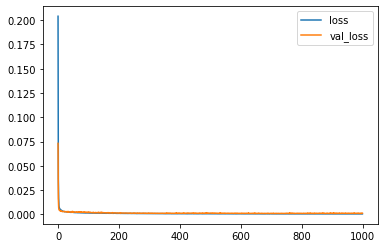

In [19]:
plt.plot(range(len(history.history['loss'])),history.history['loss'], label='loss')
plt.plot(range(len(history.history['val_loss'])),history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

## Test trained LSTM Network

In [20]:
#print(X_test)
#today = date.today()
test_prediction = model.predict(X_test)
test_prediction = (test_prediction * sc.data_range_[y_col_index]) + sc.data_min_[y_col_index]

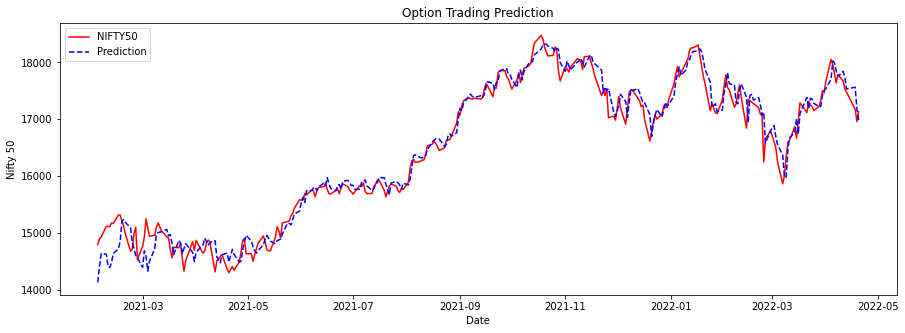

In [22]:
fig = plt.figure(figsize = (15, 5))
plt.plot(data.Date.values[ split_index+60 : ], data.Close.values[ split_index+60: ], 'r-', label = 'NIFTY50')
plt.plot(data['Date'].values[split_index+60 : ], test_prediction, 'b--', label = 'Prediction')

plt.title('Option Trading Prediction')
plt.xlabel('Date')
plt.ylabel('Nifty 50')
plt.legend()
plt.show()

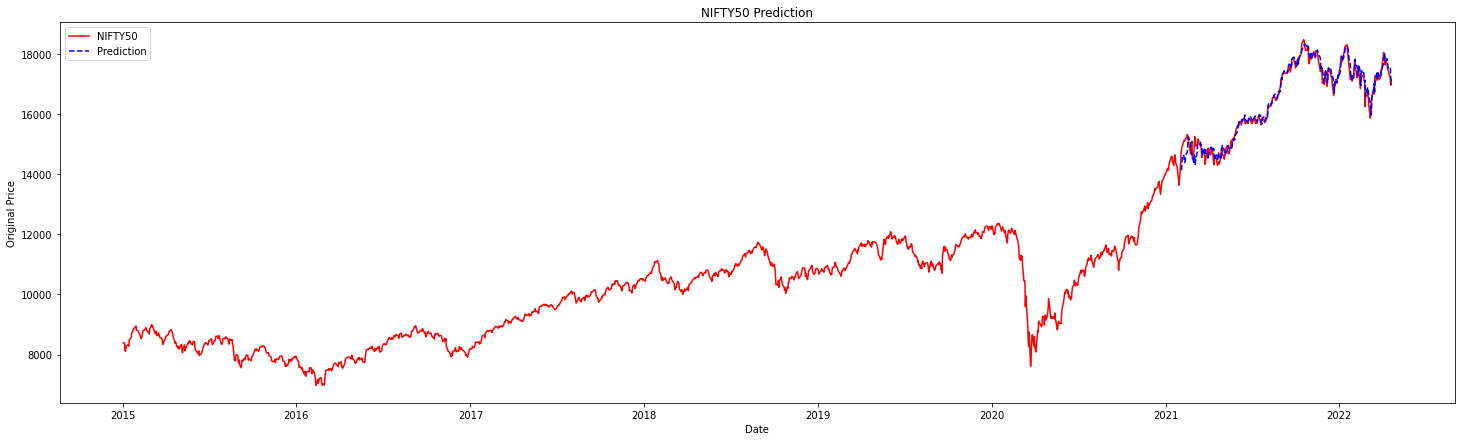

In [23]:
fig = plt.figure(figsize = (25, 7))
plt.plot(data.Date, data.Close, 'r-', label = 'NIFTY50')
plt.plot(data['Date'].values[split_index+60 : ], test_prediction, 'b--', label = 'Prediction')

plt.title('NIFTY50 Prediction')
plt.xlabel('Date')
plt.ylabel('Original Price')
plt.legend()
plt.show()

# Predicting every parameter (Open, High, Low, Close, Volume)

### Generating windowed timestamp data

In [ ]:
# this function will combine data of 20 days (we can change it using time_window parameter) 
time_window = 60      # 60 days
days_step =1         # skip 1 days in between, can be set to 1 day
def generate_data(series, time_window=20, days_step=1):
  X = []
  y = []
  for i in range(60, len(series)):
    X.append(series[i-time_window: i: days_step])
    y.append(series[i])                                 # <---- only changed this, insetead of taking only closing price, every column value is used
  return (np.array(X), np.array(y))

In [ ]:
X_train, y_train = generate_data(train_set_scaled, time_window, days_step)
X_test, y_test = generate_data(test_set_scaled, time_window, days_step)

In [ ]:
print('Training data shape (Input): ',X_train.shape)
print('Training data shape (Output): ',y_train.shape)
print('We will observe {} days price to predict next day price'.format(X_train.shape[1]))

Training data shape (Input):  (1373, 60, 5)
Training data shape (Output):  (1373, 5)
We will observe 60 days price to predict next day price


## Create Multi Layer LSTM Network

In [ ]:
model = Sequential()

# layer 1
model.add(LSTM(units = 64, return_sequences = True, input_shape = X_train.shape[1:]))
model.add(Dropout(0.2))

# layer 2
model.add(LSTM(units = 32, return_sequences = True))
model.add(Dropout(0.2))

# layer 3
model.add(LSTM(units = 16, return_sequences = True))
model.add(Dropout(0.2))

# layer 4
model.add(LSTM(units = 8, return_sequences = True))
model.add(Dropout(0.2))

# layer 4
model.add(LSTM(units = 5))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            17920     
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 32)            12416     
                                                                 
 dropout_1 (Dropout)         (None, 60, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 16)            3136      
                                                                 
 dropout_2 (Dropout)         (None, 60, 16)            0         
                                                                 
 lstm_3 (LSTM)               (None, 60, 8)             8

## Compile and train LSTM Network

In [ ]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(X_train,
                    y_train,
                    epochs = 1000,
                    batch_size = 64,
                    validation_data = (X_test, y_test))

Epoch 1/1000
22/22 [==============================] - 15s 251ms/step - loss: 0.1960 - val_loss: 0.2008
Epoch 2/1000
22/22 [==============================] - 3s 154ms/step - loss: 0.1006 - val_loss: 0.0876
Epoch 3/1000
22/22 [==============================] - 3s 147ms/step - loss: 0.0560 - val_loss: 0.0474
Epoch 4/1000
22/22 [==============================] - 4s 178ms/step - loss: 0.0278 - val_loss: 0.0282
Epoch 5/1000
22/22 [==============================] - 6s 289ms/step - loss: 0.0179 - val_loss: 0.0239
Epoch 6/1000
22/22 [==============================] - 7s 305ms/step - loss: 0.0140 - val_loss: 0.0198
Epoch 7/1000
22/22 [==============================] - 6s 254ms/step - loss: 0.0121 - val_loss: 0.0183
Epoch 8/1000
22/22 [==============================] - 3s 146ms/step - loss: 0.0108 - val_loss: 0.0152
Epoch 9/1000
22/22 [==============================] - 3s 149ms/step - loss: 0.0099 - val_loss: 0.0139
Epoch 10/1000
22/22 [==============================] - 3s 148ms/step - loss: 0.00

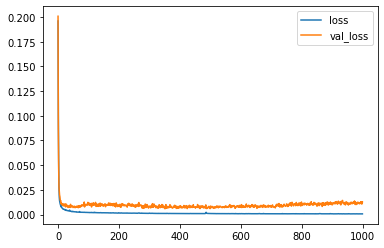

In [ ]:
plt.plot(range(len(history.history['loss'])),history.history['loss'], label='loss')
plt.plot(range(len(history.history['val_loss'])),history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

## Test trained LSTM Network 

In [ ]:
test_prediction = model.predict(X_test)
test_prediction = sc.inverse_transform(test_prediction)

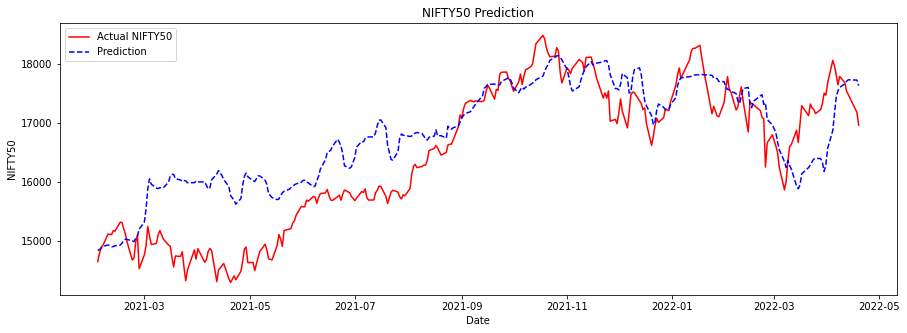

In [ ]:
fig = plt.figure(figsize = (15, 5))
plt.plot(data.Date.values[ split_index+60 : ], data.Close.values[ split_index+60: ], 'r-', label = 'Actual NIFTY50')
plt.plot(data['Date'].values[split_index+60 : ], test_prediction[:,3], 'b--', label = 'Prediction')

plt.title('NIFTY50 Prediction')
plt.xlabel('Date')
plt.ylabel('NIFTY50')
plt.legend()
plt.show()

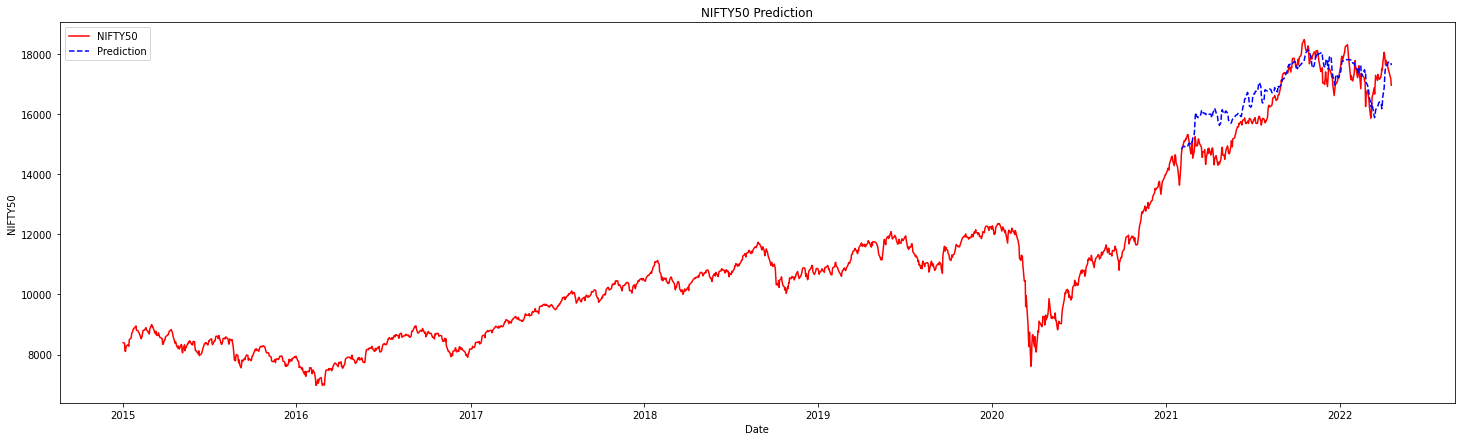

In [ ]:
fig = plt.figure(figsize = (25, 7))
plt.plot(data.Date, data.Close, 'r-', label = 'NIFTY50')
plt.plot(data['Date'].values[split_index+60 : ], test_prediction[:,3], 'b--', label = 'Prediction')

plt.title('NIFTY50 Prediction')
plt.xlabel('Date')
plt.ylabel('NIFTY50')
plt.legend()
plt.show()

In [ ]:
def predict_n_days(df, n=30, step=0.1):
    for i in range(n):
        X = df[factors_column].values[df.shape[0]-time_window::step]
        X = sc.transform(X)
        y = model.predict(np.expand_dims(X, axis=0))
        y = sc.inverse_transform(y)[0]

        next_day_prediction = { key: value for key, value in zip(factors_column, y)}
        next_day_prediction['Date'] = df.iloc[-1].Date + pd.Timedelta(days=1)
        
        df = df.append(next_day_prediction, ignore_index=True)
    return df

In [ ]:
days= 5    
#days_step =0.1   
predicted_df = predict_n_days(data,days,days_step)

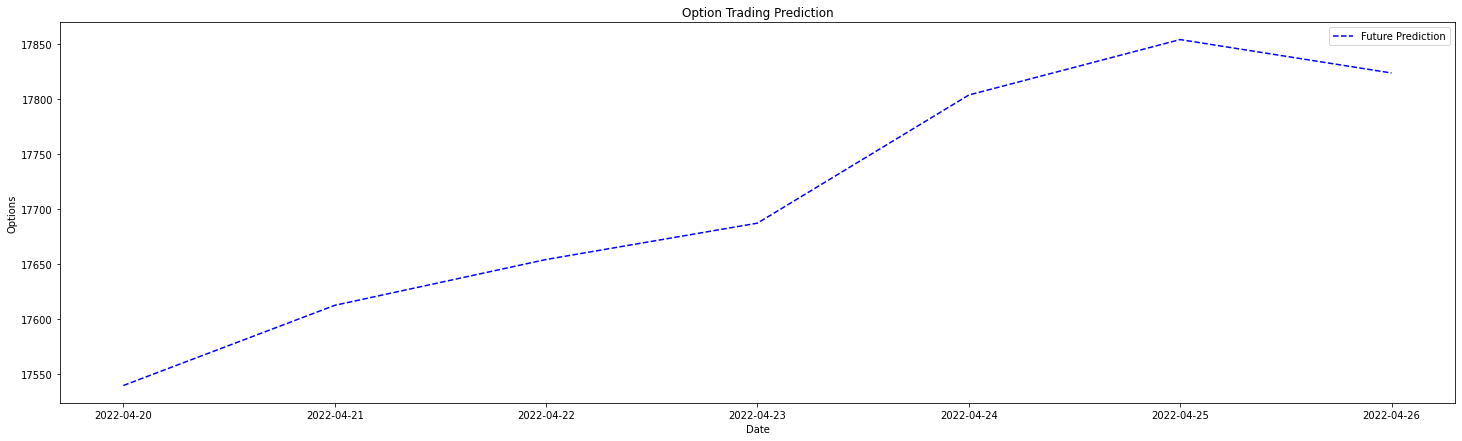

In [ ]:
fig = plt.figure(figsize = (25, 7))
#plt.plot(data.Date, data.Close, 'r-', label = 'BTC Price')
plt.plot(predicted_df.Date.values[-days: ], predicted_df.Close[-days:], 'b--', label = 'Future Prediction')

plt.title('Option Trading Prediction')
plt.xlabel('Date')
plt.ylabel('Options')
plt.legend()
plt.show()

In [ ]:
# MLP for OTP model Serialize to JSON and HDF5
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy
import os

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 


Saved model to disk


In [ ]:
# later...
 
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X_train,
                    y_train, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 70.21%
